# **Clustering and Topic Modeling on the 20 Newsgroup Dataset**

## **Data Loading and Preprocessing**

First we load the full 20 Newsgroup dataset (combining training and test splits) using sklearn.datasets.fetch_20newsgroups.  
1. To focus on content rather than metadata,**removed headers, footers, and quoted text.**  
2. **Each document is raw text;** to convert it into numerical feature vectors. **Applied standard text preprocessing: tokenization, stop-word removal, and vectorization.**  
3. For **K‑means** we use a TF-IDF representation (TfidfVectorizer), which scales word counts by inverse document frequency to force on discriminative words.  
4. **For LDA** we use raw term counts (CountVectorizer) as LDA assumes a bag-of-words model.

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# loading the 20 Newsgroups data
newsgroups = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes')) #(removing headers/footers/quotes for realism)
docs = newsgroups.data
true_labels = newsgroups.target  # integer labels numbered 0 to 19 for newsgroup categories

# converting docs to TF-IDF feature for K-means
tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_vect.fit_transform(docs)  # sparse (n_docs, n_features) TF-IDF matrix

# converting docs to raw count features for LDA
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = count_vect.fit_transform(docs)  # sparse (n_docs, n_features) count matrix

print("TF-IDF matrix shape:", X_tfidf.shape)
print("Count matrix shape:", X_counts.shape)

TF-IDF matrix shape: (18846, 51840)
Count matrix shape: (18846, 51840)


## **K-Means Clustering**

K-means partitions data so that each point is assigned to the nearest cluster centroid.  
  K-means is straightforward to apply:  
  1. Chose K = 20 (as dataset has 20 topics) and run the algorithm on the TF-IDF vectors.  
  2. After fitting, each document gets a cluster label.
  3. Also examine the top terms characterizing each cluster by looking at the centroid vector in TF-IDF space.

In [3]:
from sklearn.cluster import KMeans

k = 20
kmeans = KMeans(n_clusters=k, random_state=0)
km_labels = kmeans.fit_predict(X_tfidf)

# print cluster sizes
counts = np.bincount(km_labels)
print("Documents per K-means cluster:", counts)

# print top terms in each cluster (based on TF-IDF centroids)
feature_names = tfidf_vect.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_words = [feature_names[idx] for idx in order_centroids[i, :8]]
    print(f"Cluster {i} top terms:", ", ".join(top_words))

Documents per K-means cluster: [   12     1     1     7     1     1     1     1     1     1     1     3
     1     1     1 18738     5     1     1    67]
Cluster 0 top terms: catbyte, dtmedin, b30, ingr, 205, gd3004, 3169, medin
Cluster 1 top terms: subsidized, audio, receivers, sap, vehicle, traffic, status, la
Cluster 2 top terms: fonts, unicode, han, bitmap, roman, suitable, conversion, macintosh
Cluster 3 top terms: tyre, ezekiel, fishing, prince, people, city, wrote, village
Cluster 4 top terms: received, simplicity, edt, sooner, movie, sake, ve, tuesday
Cluster 5 top terms: ide, caching, 256k, controllers, simms, cache, spend, assuming
Cluster 6 top terms: aix, career, dan, year, yeah, years, gladden, cedeno
Cluster 7 top terms: theory, scientists, irrationality, suicides, philosophers, point, atheists, absolute
Cluster 8 top terms: hacker, change, computer, fade, uncle, gates, jail, likes
Cluster 9 top terms: error, certainly, duke, dungeon, dung, dunes, dune, duncan
Cluster 10 

**Top terms Bar Plot**

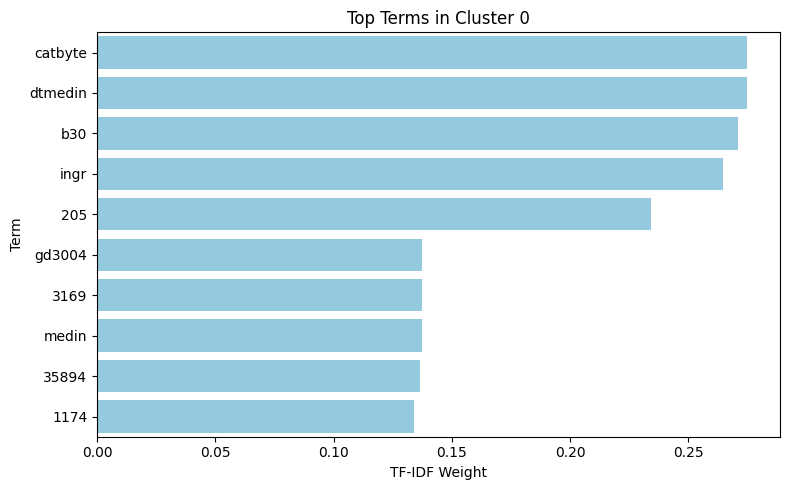

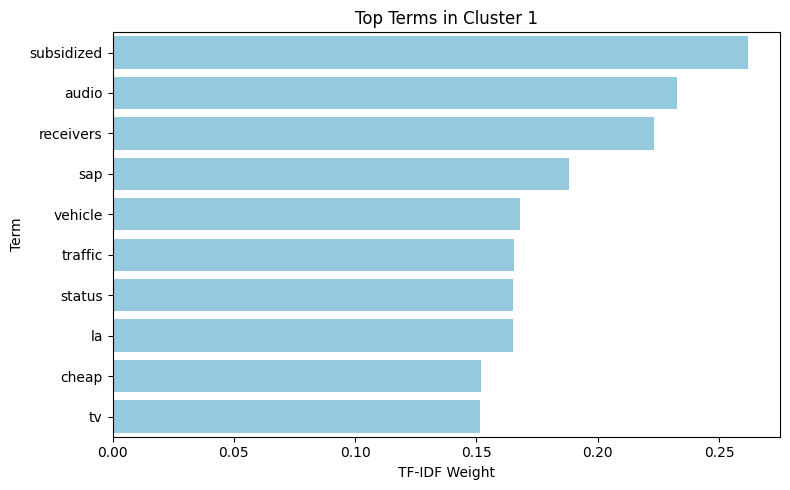

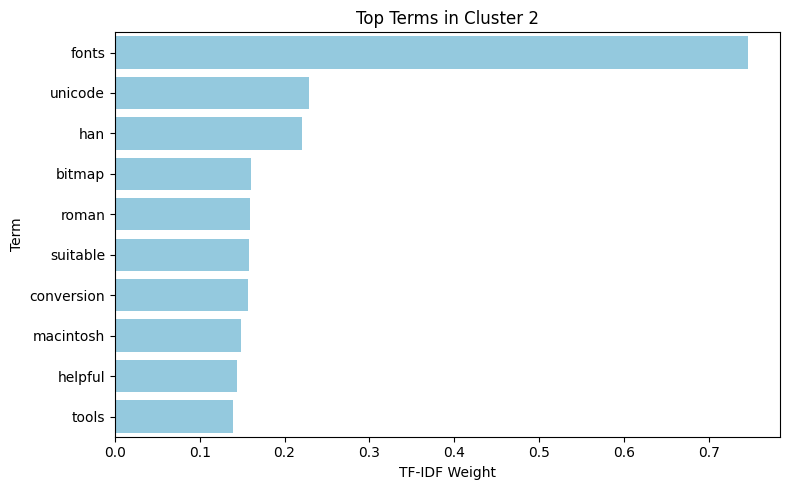

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

def plot_top_words(cluster_idx, n_words=10):
    centroid = kmeans.cluster_centers_[cluster_idx]
    top_indices = centroid.argsort()[-n_words:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    weights = centroid[top_indices]

    plt.figure(figsize=(8,5))
    sns.barplot(x=weights, y=top_terms, color='skyblue')
    plt.title(f"Top Terms in Cluster {cluster_idx}")
    plt.xlabel("TF-IDF Weight")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

# to show cluster 0,1,2
for i in range(3):    ## increase the value in range() to see more clusters
    plot_top_words(i)


**This partitions the documents into 20 clusters.**  

Let us expect (if clustering succeeds) that each cluster contains documents of similar topics. The printed “top terms” give a qualitative sense of each cluster’s theme.

**After clustering, we evaluate cluster quality.**


One key metric is the Silhouette score, which measures how similar each document is to its own cluster compared to other clusters. A silhouette value close to +1 indicates that the document is well matched to its own cluster and poorly matched to neighboring clusters; near -1 indicates possible misclassification.

In [4]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# convert sparse TF-IDF to dense or use sample for silhouette
sil_score = silhouette_score(X_tfidf, km_labels)
ari_kmeans = adjusted_rand_score(true_labels, km_labels)
print(f"K-means inertia: {kmeans.inertia_:.1f}, Silhouette: {sil_score:.3f}, ARI vs true labels: {ari_kmeans:.3f}")

K-means inertia: 18099.1, Silhouette: -0.011, ARI vs true labels: 0.000


Computed the average silhouette across all documents.

Also measured inertia (the K-means sum-of-squares criterion) and adjusted Rand index (ARI) comparing the clustering to the true labels.  
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## **Latent Dirichlet Allocation (LDA)**

**LDA is probabilistic** topic model representing each document as a mixture of K latent topics.  

Again set K = 20 topics and fit an LDA model on the count matrix.  
**The model learns a topic-word distribution**;  
For each topic, it assigns a probability to each word.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, random_state=0)
doc_topic_dist = lda.fit_transform(X_counts)  # shape (n_docs, n_topics)

# print top words for each LDA topic
words = count_vect.get_feature_names_out()
for topic_idx, comp in enumerate(lda.components_):
    top_word_indices = comp.argsort()[:-8:-1]
    top_words = [words[i] for i in top_word_indices]
    print(f"Topic {topic_idx} top words:", ", ".join(top_words))

Topic 0 top words: don, just, like, think, know, people, time
Topic 1 top words: edu, com, mm, ma, mp, mk, p2
Topic 2 top words: key, government, use, encryption, people, law, public
Topic 3 top words: said, went, people, didn, know, came, told
Topic 4 top words: data, image, use, bit, used, line, using
Topic 5 top words: israel, jews, war, people, government, jewish, israeli
Topic 6 top words: space, new, 00, sale, nasa, price, earth
Topic 7 top words: god, jesus, christ, man, lord, church, 00
Topic 8 top words: new, university, canada, insurance, national, center, city
Topic 9 top words: thanks, know, problem, like, does, use, windows
Topic 10 top words: people, think, don, does, say, believe, god
Topic 11 top words: drive, scsi, bus, controller, disk, drives, ide
Topic 12 top words: game, team, year, games, play, season, players
Topic 13 top words: medical, years, disease, like, cancer, time, patients
Topic 14 top words: ax, max, g9v, b8f, a86, pl, 145
Topic 15 top words: edu, com, 

The output is the most frequent words in each topic.  
(**For example:** Topic 0 top words: don, just, like, think, know, people, time)

**Top terms Bar Plot**

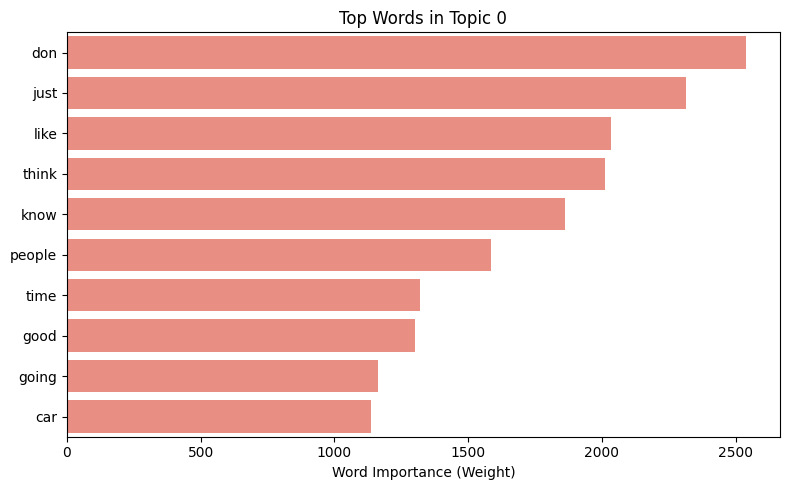

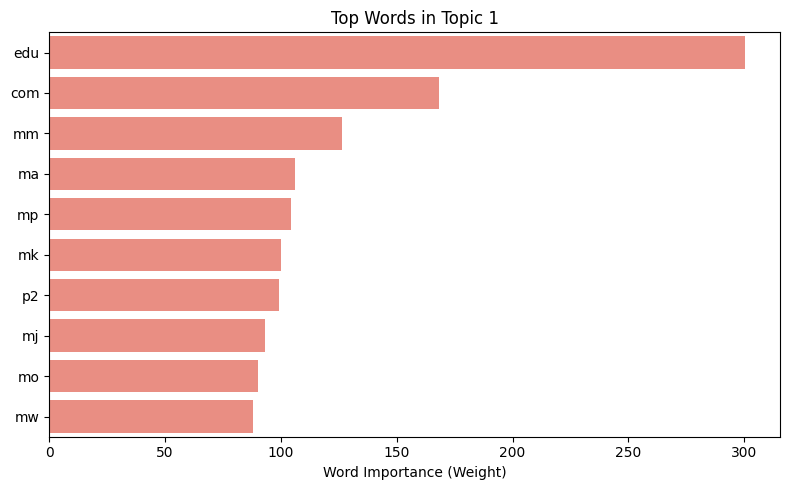

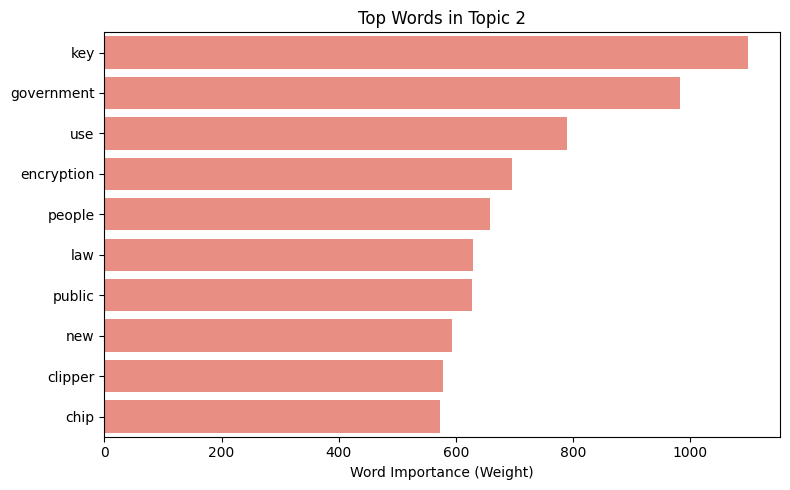

In [8]:
def plot_topic_bars(lda_model, feature_names, topic_idx, n_words=10):
    topic = lda_model.components_[topic_idx]
    top_indices = topic.argsort()[-n_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]

    plt.figure(figsize=(8,5))
    sns.barplot(x=top_weights, y=top_words, color="salmon")
    plt.title(f"Top Words in Topic {topic_idx}")
    plt.xlabel("Word Importance (Weight)")
    plt.tight_layout()
    plt.show()

# example: Plot top words in topics 0 to 2
for i in range(3):       ## increase value in range() to get more plots
    plot_topic_bars(lda, feature_names, topic_idx=i)


**My favourite (WORD CLOUD)**

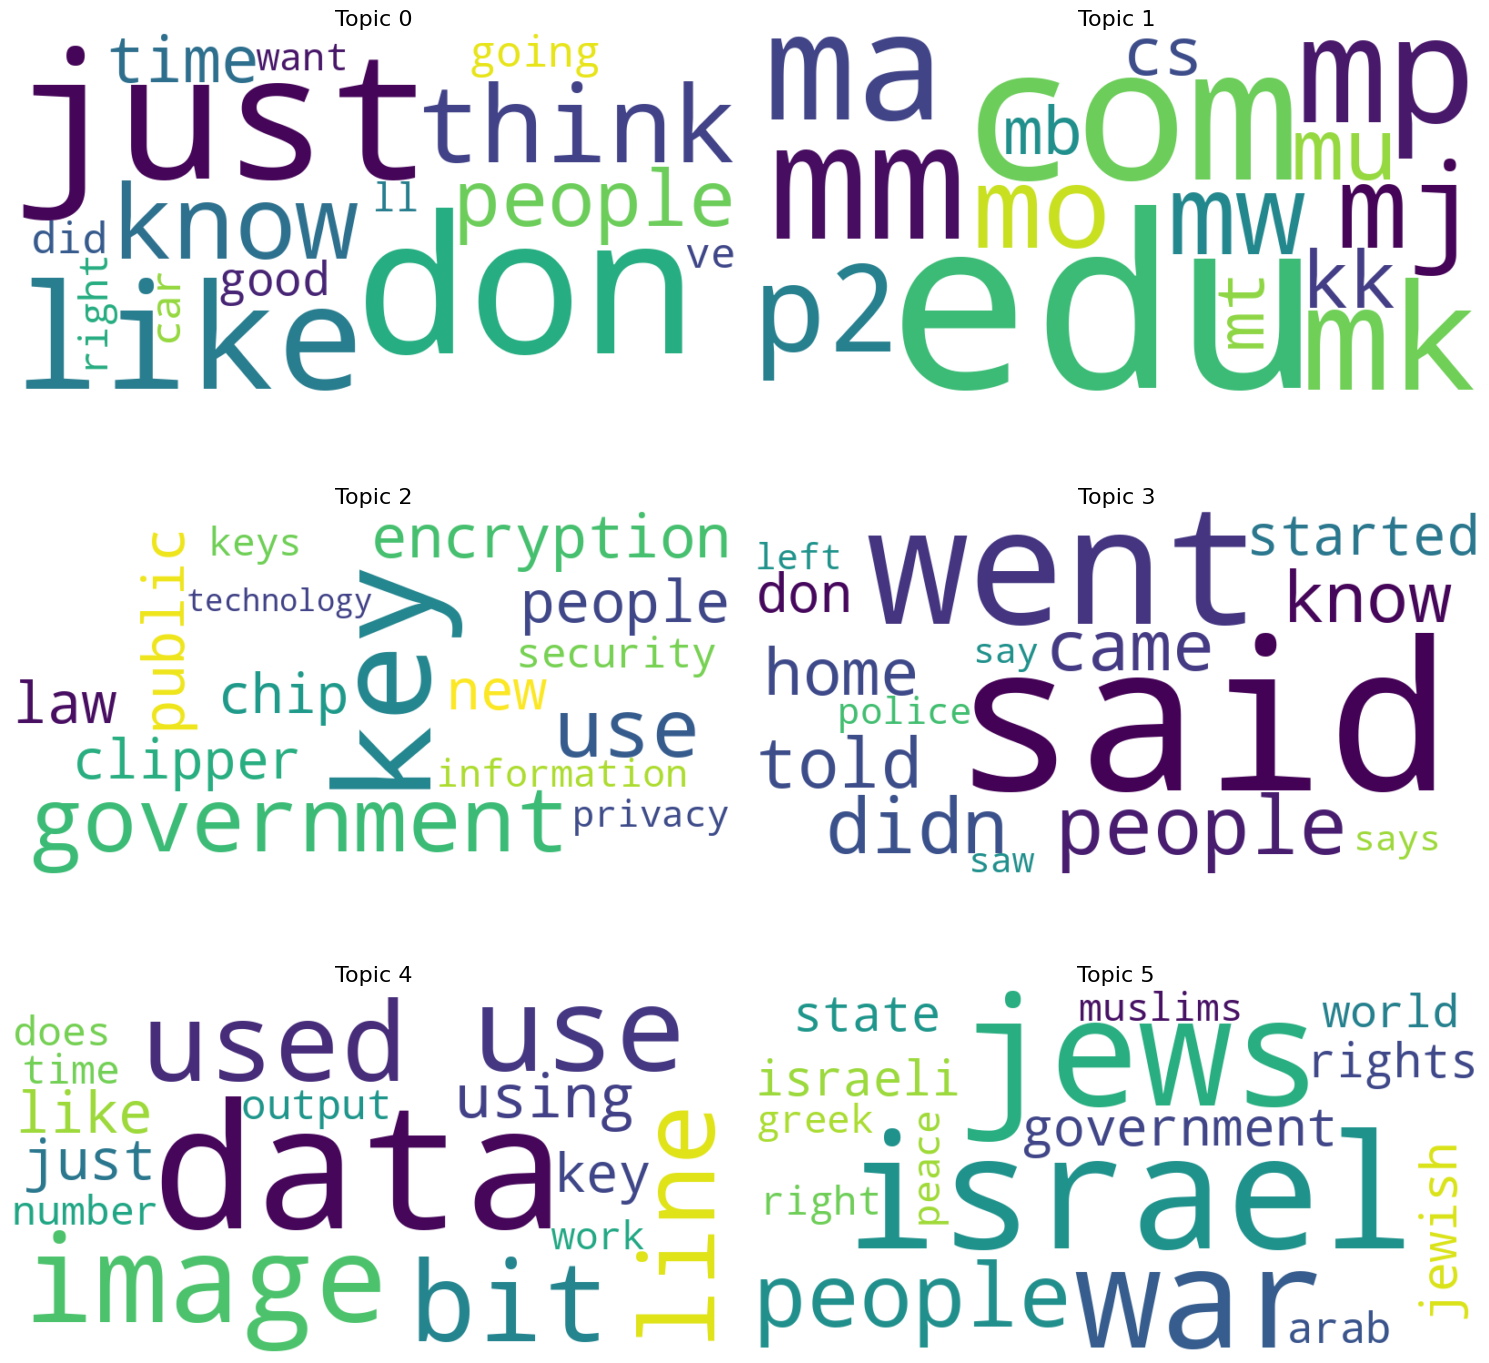

In [9]:
from wordcloud import WordCloud

def plot_wordclouds(lda_model, feature_names, n_words=15, n_topics=5):
    cols = 2
    rows = (n_topics + 1) // 2
    plt.figure(figsize=(15, 5 * rows))
    for i, topic_weights in enumerate(lda_model.components_[:n_topics]):
        top_indices = topic_weights.argsort()[-n_words:][::-1]
        words = {feature_names[j]: topic_weights[j] for j in top_indices}
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {i}", fontsize=16)
    plt.tight_layout()
    plt.show()

# use the count vectorizer's feature names
feature_names = count_vect.get_feature_names_out()
plot_wordclouds(lda, feature_names, n_words=15, n_topics=6)


**bold text**
**We evaluate LDA by computing its perplexity on the data, which measures how well the model predicts the words.**  
In scikit-learn, perplexity is defined as exp(-1 * log-likelihood per word)  ***(lower is better)***  


In [11]:
perplex = lda.perplexity(X_counts)
lda_labels = doc_topic_dist.argmax(axis=1)
ari_lda = adjusted_rand_score(true_labels, lda_labels)
print(f"LDA perplexity: {perplex:.1f}, \nARI vs true labels: {ari_lda:.3f}")

LDA perplexity: 4171.6, 
ARI vs true labels: 0.177


## **Summary**

Having demonstrated a pipeline to  
1. load text data  
2. preprocess with TF-IDF/Count vectors  
3. apply K-means and LDA  
4. Evaluate the results  

The code includes key steps (vectorization, model fitting, and metrics) and clear output of the resulting topics and cluster labels.  

The analysis provides both quantitative metrics (silhouette, inertia, perplexity, ARI) and qualitative insights (top terms per cluster/topic) to compare the two unsupervised approaches on the 20 Newsgroup dataset.